In [2]:
pip install python-chess

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.7 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sun Jun  2 12:30:40 2024

@author: ruvinjagoda
"""
import numpy as np
import chess
import pandas as pd
import tensorflow as tf
from keras import models, layers, Input, Model
from keras.optimizers import Adam
import os
from sklearn.model_selection import train_test_split

csv_file = "/kaggle/input/stockfish-eval/tactic_evals.csv"


2024-06-24 00:55:47.686228: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-24 00:55:47.686325: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-24 00:55:47.811271: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
import numpy as np
import chess

# Dictionary to map the board positions
board_positions = {
    'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7
}
# Path to the Stockfish engine
engine_path = "/Users/ruvinjagoda/Desktop/Aka/AIP/Stockfish and move/stockfish/stockfish-macos-m1-apple-silicon"
NUMOFMOVES = 2


# Function to convert square to index
def square_to_index(square):
    letter = chess.square_name(square)  # Get algebraic notation of the square
    row = 8 - int(letter[1])  # Convert rank to row index
    # Map file to column index using board_positions dictionary
    column = board_positions[letter[0]]
    return row, column  # Return row and column indices


# Function to convert board to matrix representation
def board_to_matrix(board):
    # Initialize a 3D numpy array to represent the board
    # 12 dimensions -> different chess piece types (Pawn, Knight, Bishop, Rook, Queen, King) for white and black
    # +2 dimensions -> legal moves for current player and opponent
    board_3d = np.zeros((14, 8, 8), dtype=np.int8)

    # Iterate over each piece type
    for piece in chess.PIECE_TYPES:
        # Iterate over each white piece on the board
        for square in board.pieces(piece, chess.WHITE):
            # Convert square index to row and column indices and mark the corresponding position in the matrix with 1
            index = np.unravel_index(square, (8, 8))
            # piece - 1 -> layer of 3D array corresponding to piece type (0-5)
            # 7 - index[0] -> row index (row numbering in chess module is reversed)
            # index[1] -> column index
            board_3d[piece - 1][7 - index[0]][index[1]] = 1

        # Iterate over each black piece on the board
        for square in board.pieces(piece, chess.BLACK):
            # Convert square index to row and column indices, and mark the corresponding position in the matrix with 1
            index = np.unravel_index(square, (8, 8))
            # piece + 5 -> layer of 3D array corresponding to black piece type (6-11)
            # 7 - index[0] -> row index (row numbering in chess module is reversed)
            # index[1] -> column index
            board_3d[piece + 5][7 - index[0]][index[1]] = 1

    # Store legal moves for the current player
    aux = board.turn
    board.turn = chess.WHITE
    for move in board.legal_moves:
        i, j = square_to_index(move.to_square)
        board_3d[12][i][j] = 1  # Layer 12

    # Store legal moves for the opponent player
    board.turn = chess.BLACK
    for move in board.legal_moves:
        i, j = square_to_index(move.to_square)
        board_3d[13][i][j] = 1  # Layer 13

    # Restore the original player turn
    board.turn = aux

    return board_3d  # Return the 3D matrix representation


# Convert move to label
def move_to_label(move):
    from_square = move.from_square
    to_square = move.to_square
    return from_square * 64 + to_square

def stockfish_eval(evaluation):
    # Define the max and min evaluation values for normalization
    max_eval = 2000  # Large positive value for mate in n
    min_eval = -2000  # Large negative value for mate in n

    # Normalize evaluation
    if isinstance(evaluation, str) and evaluation.startswith('#'):
        # Checkmate scenarios
        if evaluation.startswith('#-'):
            evaluation = min_eval  # Large negative value for mate in n
        else:
            evaluation = max_eval   # Large positive value for mate in n
    else:
        # Convert evaluation to float
        evaluation = float(evaluation)
        # Clip values to the range [-2000, 2000]
        evaluation = max(min(evaluation, max_eval), min_eval)

    # Normalize to range [0, 1]
    normalized_eval = (evaluation - min_eval) / (max_eval - min_eval)
    
    return normalized_eval



In [5]:
# Function to preprocess data from CSV
def preprocess_data(csv_file):
    data = pd.read_csv(csv_file)
    data = data[:1500000]
    X1, X2, y = [], [], []

    for i, (_, row) in enumerate(data.iterrows(), 1):
        if pd.isna(row['FEN']) or pd.isna(row['Move']) or pd.isna(row['Evaluation']):
            continue
        try:
            board = chess.Board(row['FEN'])
            move = chess.Move.from_uci(str(row['Move']))
            evaluation = row['Evaluation']
            X1.append(board_to_matrix(board))
            matrixMove = np.array(move_to_label(move))
            X2.append(tf.one_hot(matrixMove, depth=4096, dtype=tf.uint8))
            y.append(evaluation)
        except (ValueError, TypeError) as e:
            # Handle incorrect move formats or invalid board states
            print(f"Error processing row: {row}, error: {e}")
            continue
        
        # Print progress for every 1000 rows processed
        if i % 10000 == 0:
            print(f"Processed {i} rows out of {len(data)}")

    return np.array(X1), np.array(X2), np.array(y)


X1, X2, y = preprocess_data(csv_file)

# Print processed data for every 1000 rows
print(f"X1 shape: {X1.shape}, X2 shape: {X2.shape}, y shape: {y.shape}")
import h5py




Processed 10000 rows out of 1500000
Processed 20000 rows out of 1500000
Processed 30000 rows out of 1500000
Processed 40000 rows out of 1500000
Processed 50000 rows out of 1500000
Processed 60000 rows out of 1500000
Processed 90000 rows out of 1500000
Processed 100000 rows out of 1500000
Processed 110000 rows out of 1500000
Processed 120000 rows out of 1500000
Processed 140000 rows out of 1500000
Processed 150000 rows out of 1500000
Processed 160000 rows out of 1500000
Processed 170000 rows out of 1500000
Processed 180000 rows out of 1500000
Processed 190000 rows out of 1500000
Processed 210000 rows out of 1500000
Processed 220000 rows out of 1500000
Processed 230000 rows out of 1500000
Processed 240000 rows out of 1500000
Processed 250000 rows out of 1500000
Processed 260000 rows out of 1500000
Processed 280000 rows out of 1500000
Processed 290000 rows out of 1500000
Processed 300000 rows out of 1500000
Processed 310000 rows out of 1500000
Processed 320000 rows out of 1500000
Processe

# run from here

In [6]:
'''
import h5py
with h5py.File('/kaggle/input/stockfish-eval/processed_eval_100000_row.h5', 'r') as hf:
    X1 = hf['X1'][:]
    X2 = hf['X2'][:]
    y = hf['y'][:]
    
    
print("complete")
   
    '''

'\nimport h5py\nwith h5py.File(\'/kaggle/input/stockfish-eval/processed_eval_100000_row.h5\', \'r\') as hf:\n    X1 = hf[\'X1\'][:]\n    X2 = hf[\'X2\'][:]\n    y = hf[\'y\'][:]\n    \n    \nprint("complete")\n   \n    '

Filtered data shapes: X1: (1267219, 14, 8, 8), X2: (1267219, 4096), y: 1267219


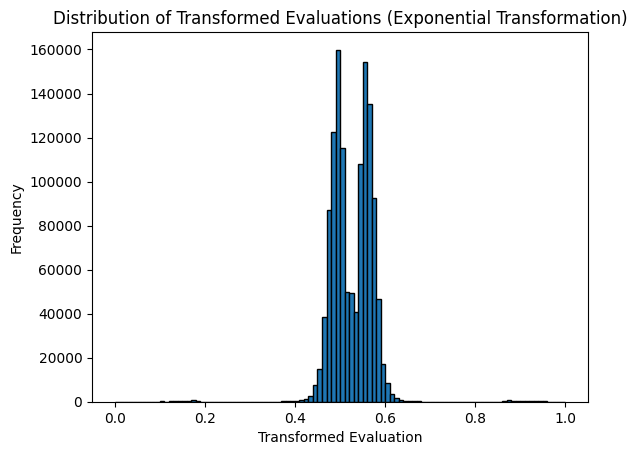

In [7]:
# Decode byte strings to regular strings
y = [evaluation.decode('utf-8') if isinstance(evaluation, bytes) else evaluation for evaluation in y]
# Check if the evaluation value is numeric
def is_numeric(value):
    try:
        float(value)
        return True
    except ValueError:
        return False

# Filter out non-numeric values
filtered_indices = [i for i, evaluation in enumerate(y) if is_numeric(evaluation) or not evaluation.startswith('#')]
filtered_X1 = X1[filtered_indices]
filtered_X2 = X2[filtered_indices]
filtered_y = [y[i] for i in filtered_indices]


print(f"Filtered data shapes: X1: {filtered_X1.shape}, X2: {filtered_X2.shape}, y: {len(filtered_y)}")

filtered_y = np.array(filtered_y)
# Convert string values to NaN (Not a Number)
filtered_y_numeric = np.array([float(val) if isinstance(val, str) else val for val in filtered_y], dtype=np.float64)

# Filter out NaN values
filtered_y_numeric = filtered_y_numeric[~np.isnan(filtered_y_numeric)]
normalized_y = (filtered_y_numeric - np.min(filtered_y_numeric)) / (np.max(filtered_y_numeric) - np.min(filtered_y_numeric))

# Apply a tanh transformation to compress towards -1 and 1
transformed_y =  normalized_y
import matplotlib.pyplot as plt
# Plot the distribution of transformed y values
plt.hist(transformed_y, bins=100, edgecolor='black')
plt.xlabel('Transformed Evaluation')
plt.ylabel('Frequency')
plt.title('Distribution of Transformed Evaluations (Exponential Transformation)')
plt.show()

In [8]:
from keras import models, layers, Input, Model
from keras.optimizers import Adam
import os
from sklearn.model_selection import train_test_split
# Function to create or load a model
def create_model(weights_path=None):

    model = models.Sequential([
        layers.Conv2D(64, (3, 3), activation='relu', input_shape=(14, 8, 8), padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.1),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),

        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.05),

        layers.Flatten(),
        layers.Dense(1024, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.1),

        layers.Dense(1, activation='sigmoid')
    ])

    

    if weights_path:
        model.load_weights(weights_path)

    return model

In [9]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
model = create_model()
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='mean_squared_error',
              metrics=['mean_squared_error'])

# Split data into training and validation sets
split_ratio = 0.9  # 90% for training, 10% for validation
split_index = int(len(filtered_X1) * split_ratio)

X1_train, X1_val = filtered_X1[:split_index], filtered_X1[split_index:]

y_train, y_val = transformed_y[:split_index], transformed_y[split_index:]

# Define training parameters
batch_size = 128
epochs = 30


early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=1e-4,
    restore_best_weights=True
)

# ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    min_delta=1e-4,
    min_lr=1e-7
)
# Training the model
history = model.fit(
    X1_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X1_val, y_val),
    callbacks=[early_stopping,reduce_lr]
)

# Save the model
save_dir = "/kaggle/working/model_weights_s"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
model.save(os.path.join(save_dir, "model_weights_x.h5"))



/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30


2024-06-24 01:23:30.867154: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 6.64892, expected 5.69733
2024-06-24 01:23:30.867201: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 111: 8.1686, expected 7.21702
2024-06-24 01:23:30.867218: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 119: 6.33772, expected 5.51375
2024-06-24 01:23:30.867240: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 791: 7.5588, expected 6.58809
2024-06-24 01:23:30.867255: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 888: 7.44436, expected 6.47366
2024-06-24 01:23:30.867266: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 895: 8.19179, expected 7.22109
2024-06-24 01:23:30.867278: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1015: 7.1998, expected 6.35856
2024-06-24 01:23:30.867289: E external/local_

  27/8911 ━━━━━━━━━━━━━━━━━━━━ 52s 6ms/step - loss: 0.0679 - mean_squared_error: 0.0679   

I0000 00:00:1719192217.984210     147 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


8904/8911 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0113 - mean_squared_error: 0.0113

2024-06-24 01:24:31.419110: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 455: 5.75081, expected 6.65833
2024-06-24 01:24:31.419169: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 559: 5.90167, expected 6.80919
2024-06-24 01:24:31.419179: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 679: 6.81387, expected 7.79238
2024-06-24 01:24:31.419198: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3255: 4.83028, expected 5.53972
2024-06-24 01:24:31.419207: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3479: 7.85607, expected 8.84869
2024-06-24 01:24:31.419216: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3583: 7.87001, expected 8.86263
2024-06-24 01:24:31.419224: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3703: 4.79872, expected 5.73091
2024-06-24 01:24:31.419232: E externa

8911/8911 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0113 - mean_squared_error: 0.0113

2024-06-24 01:24:40.395185: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1575: 7.97729, expected 7.05142
2024-06-24 01:24:40.395235: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2247: 7.65817, expected 6.71125
2024-06-24 01:24:40.395245: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2344: 8.19732, expected 7.25041
2024-06-24 01:24:40.395253: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2351: 8.24889, expected 7.30198
2024-06-24 01:24:40.395261: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2359: 7.81493, expected 6.82069
2024-06-24 01:24:40.395269: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2456: 7.96755, expected 6.97331
2024-06-24 01:24:40.395277: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2463: 8.76378, expected 7.76954
2024-06-24 01:24:40.395289: E exte

8911/8911 ━━━━━━━━━━━━━━━━━━━━ 79s 7ms/step - loss: 0.0113 - mean_squared_error: 0.0113 - val_loss: 0.0021 - val_mean_squared_error: 0.0021 - learning_rate: 1.0000e-04
Epoch 2/30
8911/8911 ━━━━━━━━━━━━━━━━━━━━ 53s 6ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0020 - val_mean_squared_error: 0.0020 - learning_rate: 1.0000e-04
Epoch 3/30
8911/8911 ━━━━━━━━━━━━━━━━━━━━ 53s 6ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0019 - val_mean_squared_error: 0.0019 - learning_rate: 1.0000e-04
Epoch 4/30
8911/8911 ━━━━━━━━━━━━━━━━━━━━ 53s 6ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0019 - val_mean_squared_error: 0.0019 - learning_rate: 1.0000e-04
Epoch 5/30
8911/8911 ━━━━━━━━━━━━━━━━━━━━ 53s 6ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0019 - val_mean_squared_error: 0.0019 - learning_rate: 1.0000e-04
Epoch 6/30
8911/8911 ━━━━━━━━━━━━━━━━━━━━ 53s 6ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.001

In [10]:
# Evaluate the model using the validation set
loss, mse = model.evaluate(X1_val, y_val)
print(f"Validation Loss: {loss:.4f}, Validation Mean Squared Error: {mse:.4f}")

2024-06-24 01:29:59.081978: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2344: 6.97939, expected 7.95536
2024-06-24 01:29:59.082046: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2351: 6.58279, expected 7.55876
2024-06-24 01:29:59.082058: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2583: 6.43377, expected 7.29015
2024-06-24 01:29:59.082067: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2695: 5.91662, expected 6.78358
2024-06-24 01:29:59.082079: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3479: 5.70544, expected 6.61564
2024-06-24 01:29:59.082094: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3583: 7.12046, expected 8.03065
2024-06-24 01:29:59.082113: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5711: 6.00397, expected 6.96981
2024-06-24 01:29:59.082130: E exte

3961/3961 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.0020 - mean_squared_error: 0.0020
Validation Loss: 0.0020, Validation Mean Squared Error: 0.0020


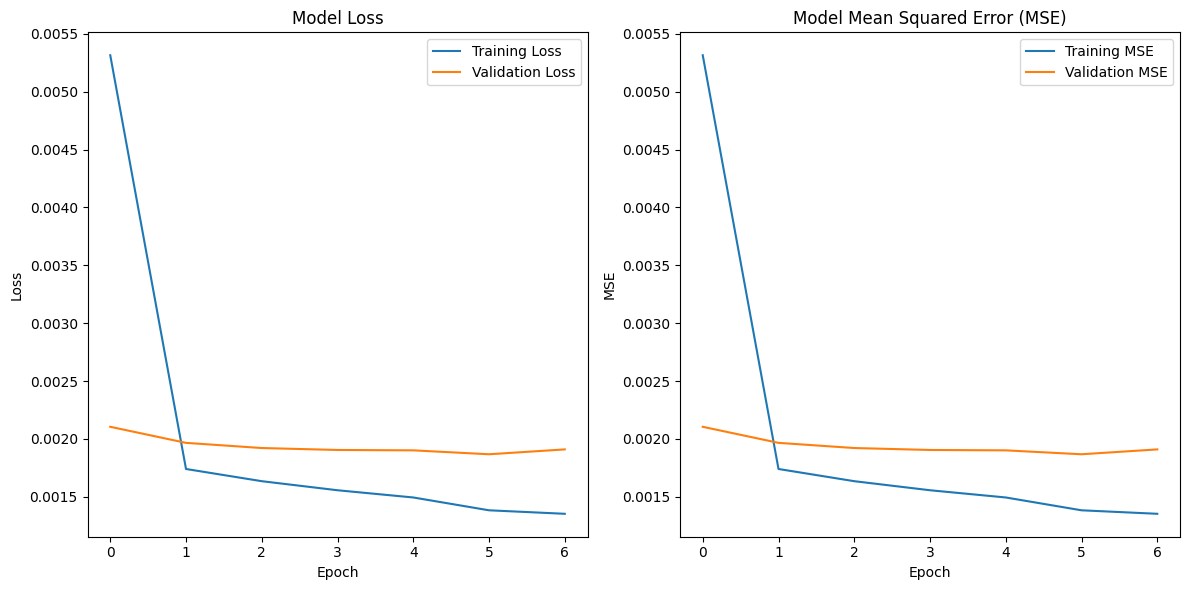

In [11]:
import matplotlib.pyplot as plt
# Plot training history
plt.figure(figsize=(12, 6))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation mean squared error (MSE) values
plt.subplot(1, 2, 2)
plt.plot(history.history['mean_squared_error'], label='Training MSE')
plt.plot(history.history['val_mean_squared_error'], label='Validation MSE')
plt.title('Model Mean Squared Error (MSE)')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

plt.tight_layout()
plt.show()


In [12]:
import numpy as np

# Assuming X1_val is your validation input data
# Assuming model is your trained Keras model

# Generate predictions from the validation set
predictions = model.predict(X1_val)

# Get the number of samples in X1_val
num_samples = X1_val.shape[0]

# Select 100 random indices from X1_val
random_indices = np.random.choice(num_samples, size=100, replace=False)

# Print out the random predictions and their corresponding inputs
print("Random 100 Predictions:")
for idx in random_indices:
    prediction = predictions[idx]
    input_data = X1_val[idx]  # Assuming you want to print the input data as well
    
    print(f"Prediction: {prediction}")

# Note: Adjust the printing format and data access based on your actual data structure


3961/3961 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
Random 100 Predictions:
Prediction: [0.5388098]
Prediction: [0.52703774]
Prediction: [0.5426625]
Prediction: [0.5029855]
Prediction: [0.52423185]
Prediction: [0.5263343]
Prediction: [0.5078015]
Prediction: [0.5466531]
Prediction: [0.5050446]
Prediction: [0.53640085]
Prediction: [0.5038702]
Prediction: [0.51132005]
Prediction: [0.51006055]
Prediction: [0.5121593]
Prediction: [0.5157943]
Prediction: [0.5192325]
Prediction: [0.5376167]
Prediction: [0.5244512]
Prediction: [0.531142]
Prediction: [0.53250724]
Prediction: [0.54138577]
Prediction: [0.52019095]
Prediction: [0.54196644]
Prediction: [0.5175154]
Prediction: [0.52329135]
Prediction: [0.5260993]
Prediction: [0.5372525]
Prediction: [0.5153748]
Prediction: [0.5212067]
Prediction: [0.5148396]
Prediction: [0.524496]
Prediction: [0.5452129]
Prediction: [0.53338236]
Prediction: [0.5279296]
Prediction: [0.5378275]
Prediction: [0.5136589]
Prediction: [0.5349103]
Prediction: [0.5465706]
Prediction: 

In [13]:
# Assuming X1, X2, y are obtained from preprocess_data(csv_file)
with h5py.File('/kaggle/working/processed_eval_1500000_row.h5', 'w') as hf:
    hf.create_dataset('X1', data=filtered_X1)
    hf.create_dataset('X2', data=filtered_X2)
    hf.create_dataset('y', data=filtered_y_numeric)